In [255]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import tensorflow as tf
import tensorflow.keras.backend as kb
tfd = tfp.distributions

seed = 1
np.random.seed(seed)

plt.rcParams['figure.figsize'] = (8,8)
plt.rcParams['figure.dpi'] = 80

In [256]:
def A_i_j(x, y, K, g):    
    with tf.GradientTape() as tape:
        # print('x shape: {}, y shape: {}'.format(x.shape, y.shape))
        tape.watch(x)
        tape.watch(y)
        z = K.apply(x,y)
        # print('kernel shape: {}'.format(z.shape))
    dzdx, dzdy = tape.gradient(z, [x,y])
    # print('gradient shape: {}'.format(dzdx.shape))
    vfx = tf.math.reduce_sum(dzdx*tf.transpose(tf.convert_to_tensor(g(x), dtype=tf.float32)),axis=1)
    vfy = tf.math.reduce_sum(dzdy*tf.transpose(tf.convert_to_tensor(g(y), dtype=tf.float32)),axis=1)
    print('vfx shape: {}'.format(vfx.shape))
    # print('vfy shape: {}'.format(vfy.shape))

    product = tf.tensordot(vfx, vfy, axes=0)
    # make sure it is invertible
    product = product + tf.eye(product.shape[0])* 10e-6
    return product

In [257]:
def get_s(x, y, K, g, a = None):
    # x: (n_x, d)
    # y: (n_y, d)
    x = tf.repeat(x, repeats=[y.shape[0]], axis=0)
    # print('x: {}'.format(x.shape))
    with tf.GradientTape() as tape:
        tape.watch(y)
        kernel = K.apply(x,y) # (n_x,) 
        grad = tape.gradient(kernel,y) # (n_x, dim)
        # print(grad)
    inner_product = kb.sum(grad*kb.transpose(tf.convert_to_tensor(g(y), dtype=tf.float32)),axis=0)[..., tf.newaxis] # (dim, 1)
    s = tf.tensordot(a, inner_product, axes=1)
    s = tf.squeeze(s)
    return s


In [258]:
from numpy import dtype


g_kernel = tfp.math.psd_kernels.ExponentiatedQuadratic()
n_y = 90
dim = 2
bounds = [1.6, 4]
omega_domain = np.array([np.random.uniform(-bounds[0], bounds[0],n_y), 
                            np.random.uniform(-bounds[1],bounds[1],n_y)]).T


# def vf(x):
#     y = [-x[:,0]-10.*x[:,1]**2,-2.*x[:,1]]
#     return y

# van poole equation
def vf(x):
    y = [-x[:,1], x[:,0] - (1-x[:,0]**2)*x[:,1]]
    return y

# x = tf.ones([n_x, dim], tf.float32)

data_points = tf.constant(omega_domain, dtype=tf.float32)

target_values = - tf.square(data_points)

product = A_i_j(data_points, target_values, g_kernel, vf)

alphas = tf.linalg.solve(product, target_values)

trial_x = tf.constant([[-1.1, 4.1]], tf.float32)

approx = get_s(trial_x, data_points, g_kernel, vf, alphas)

vfx shape: (90,)


In [259]:
tf.norm(data_points)

<tf.Tensor: shape=(), dtype=float32, numpy=25.417425>

In [260]:
n_x = 20
this_x = np.linspace(-bounds[0], bounds[0], n_x)
y = np.linspace(-bounds[1], bounds[1], n_x)

X, Y = np.meshgrid(this_x, y)

s = X.shape

Ze = np.zeros(s)
Zp = np.zeros(s)
DT = np.zeros((n_x**2,dim))

# convert mesh into point vector for which the model can be evaluated
c = 0
for i in range(s[0]):
    for j in range(s[1]):
        DT[c,0] = X[i,j]
        DT[c,1] = Y[i,j]
        c = c+1;
# define vector field for plot
new_vf = np.reshape(np.array(vf(DT)), (dim, n_x, n_x))

In [261]:
solution = np.empty((n_x**2, n_y))

for ind, i in enumerate(DT):
    x = tf.constant([i], tf.float32)
    solution[ind, :] = get_s(x, data_points, g_kernel, vf, alphas)

In [262]:
trial_solution = tf.reduce_sum(solution, axis=1)
trial_solution = tf.reshape(trial_solution, (n_x, n_x))

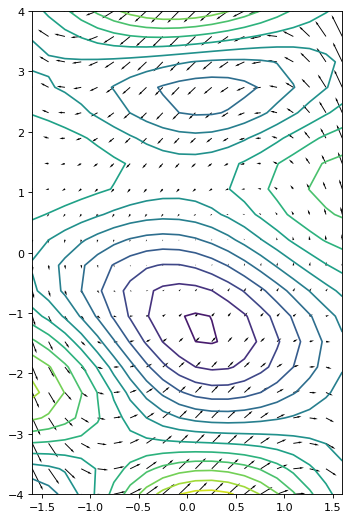

In [263]:
plt.figure(figsize=(5,8))
plt.contour(this_x,y, trial_solution, levels=15)
plt.quiver(X,Y, new_vf[0], new_vf[1], headwidth=2, headlength=4)
plt.show()